# Tutorial: **$\delta$ HBV 2.0**

---

This notebook demonstrates how to forward a pre-trained $\delta$ HBV 2.0UH model developed by [Yalan Song et al. (2024)](https://doi.org/10.22541/essoar.172736277.74497104/v1). For explanation of model structure, methodologies, [data](https://mhpi.github.io/datasets/CONUS/#results), and performance metrics, please refer to Song's publication [below](#publication). If you find this code is useful in your own work, please include the aforementioned citation.

<br>

#### Before Running:
- **Environment**: From `env/` a minimal Python environment can be setup for running this code... (see `docs/getting_started.md` for more details.)
    - Conda -- `deltamodel_env.yaml`
    - Pip -- `requirements.txt`


- **Model and Data**: The trained $\delta$ HBV 2.0 model and input data can be downloaded from [sharepoint](https://pennstateoffice365-my.sharepoint.com/:f:/g/personal/cxs1024_psu_edu/Eqi1NuJ3d2pMpEJpVu0EGSoBigi-VCWVHgOYIRoTeuGiOw?e=HaNNeA). After downloading...

    1. Update the `subbasin_data_path` key in data config `example/conf/observations/merit_forward.yaml` with your path to `MERIT_input_sample/71_0`.

    2. Update the `trained_model` key in model config `example/conf/config_dhbv_2_0.yaml` with the path to you directory containing the trained model `dHBV_2_0_Ep100.pt` AND normalization file `normalization_statistics.json`.

- **Hardware**: The LSTMs used in this model require CUDA support only available with Nvidia GPUs. For those without access, T4 GPUs can be used when running this notebook with dMG on [Google Colab](https://colab.research.google.com/).




### Publication:

*Song, Yalan, Tadd Bindas, Chaopeng Shen, Haoyu Ji, Wouter Johannes Maria Knoben, Leo Lonzarich, Martyn P. Clark et al. "High-resolution national-scale water modeling is enhanced by multiscale differentiable physics-informed machine learning." Authorea Preprints (2024). https://essopenarchive.org/doi/full/10.22541/essoar.172736277.74497104.*

<br>

### Issues:
For questions, concerns, bugs, etc., please reach out by posting an issue on the [dMG repo](https://github.com/mhpi/generic_deltaModel/issues).

---

<br>

## 1. Train/Evaluate $\delta$ HBV 2.0

*Multiscale training for dHBV2.0 is not currently enabled in dMG. Training code will be released at a later time.*

## 2. Forward $\delta$ HBV 2.0

After completing [these](#before-running) steps, forward the $\delta$ HBV 2.0 model with the code block below.

--> For default settings expect evaluation time of ~2 minutes with an Nvidia A100.

**Note**
- The settings defined in `../example/conf/config_dhbv_2_0.yaml` are set to replecate benchmark performance.
- For model evaluation, set `mode: predict` in `example/conf/config_dhbv_2_0.yaml`, or modify after the config dict has been created (see below).
- The default inference window is set from 1 January 1980 to 31 December 2020, which should use ~70GB of vram.
- The first year (`warm_up` in the config, 365 days is default) of the inference period is used for initializing HBV's internal states (water storages) and is, therefore, excluded from the model's prediction output.
- If you are new to the *dMG* framework and want further explanation and exposure of the methods used below, we suggest first looking at our notebook for $\delta$ HBV 1.0: `example/hydrology/example_dhbv_1_0.ipynb`.

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../../deltaModel')  # Add the dMG root directory.

from example import load_config 
from models.model_handler import ModelHandler as dHBV
from core.utils import print_config
from core.utils.module_loaders import get_data_loader, get_trainer
from trainers.trainer_ms import Trainer
from core.data.data_loaders.loader_hydro_ms import get_dataset_dict



#------------------------------------------#
# Define model settings here.
CONFIG_PATH = '../example/conf/config_dhbv_2_0.yaml'
#------------------------------------------#



# 1. Load configuration dictionary of model parameters and options.
config = load_config(CONFIG_PATH)
print_config(config)

# 2. Setup a dataset dictionary of NN and physics model inputs.
# data_loader = get_data_loader(config['data_loader'])
# data_loader = data_loader(config, test_split=True, overwrite=False)
inference_dataset = get_dataset_dict(config, train=False)

# 3. Initialize the differentiable model dHBV 2.0 (LSTM + HBV 2.0).
model = dHBV(config, verbose=True)

# 4. Initialize trainer to handle forward pass.
trainer = get_trainer(config['trainer'])
trainer = trainer(
    config,
    model,
    inf_dataset=inference_dataset,
    eval_dataset= inference_dataset,
    verbose=True,
)

# 5. Forward pass through the model to get streamflow predictions.
predictions = trainer.inference()


Current Configuration
  Experiment Mode:    predict             
  Model 1:            HBV_2_0             

Data Loader
  Data Source:        merit_forward       
  Predict Range :     1980/01/01          2020/12/31          

Model Parameters
  Train Epochs:       100                 Batch Size:         100                 
  LSTM Dropout:       0.5                 LSTM Hidden Size:   64                  
  MLP Dropout:        0.5                 MLP Hidden Size:    4096                
  Warmup:             0                   Concurrent Models:  4                   
  Loss Fn:            RmseLossComb        

Machine
  Use Device:         cuda:0              



Inference:   0%|          | 0/8 [00:00<?, ?it/s]/projects/mhpi/lglonz/project_silmaril/generic_deltaModel/example/hydrology/../../deltaModel/models/neural_networks/lstm_models.py:104: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  output, hy, cy, reserve, new_weight_buf = torch._cudnn_rnn(


### Visualizing Model Predictions

After running model inference we can, e.g., view the hydrograph for one of the catchments to see we are getting expected outputs.

We can do this with our target variable, streamflow, for instance... (though, there are many other states and fluxes we can output as shown in the output cell below.)

In [2]:
predictions.keys()

dict_keys(['flow_sim', 'srflow', 'ssflow', 'gwflow', 'AET_hydro', 'PET_hydro', 'SWE', 'flow_sim_no_rout', 'srflow_no_rout', 'ssflow_no_rout', 'gwflow_no_rout', 'recharge', 'excs', 'evapfactor', 'tosoil', 'percolation', 'capillary', 'BFI_sim'])

In [9]:
import zarr

DATA_PATH = '/projects/mhpi/yxs275/model/generic_deltaModel_dhbv2.0/data/71_0'

# Load zarr store of data.
root = zarr.open_group(DATA_PATH, mode='r+')
comids = root['COMID'][:]

array([71024425., 71024599., 71027691., ..., 71044115., 71044117.,
       71044118.])

HBV states and fluxes: dict_keys(['flow_sim', 'srflow', 'ssflow', 'gwflow', 'AET_hydro', 'PET_hydro', 'SWE', 'flow_sim_no_rout', 'srflow_no_rout', 'ssflow_no_rout', 'gwflow_no_rout', 'recharge', 'excs', 'evapfactor', 'tosoil', 'percolation', 'capillary', 'BFI_sim']) 

First 20 available COMIDs: 
 [71024425. 71024599. 71027691. 71027697. 71027699. 71027712. 71028290.
 71028297. 71028376. 71028384. 71029220. 71029794. 71029974. 71030418.
 71030425. 71030444. 71030448. 71030457. 71030478. 71030509.] 



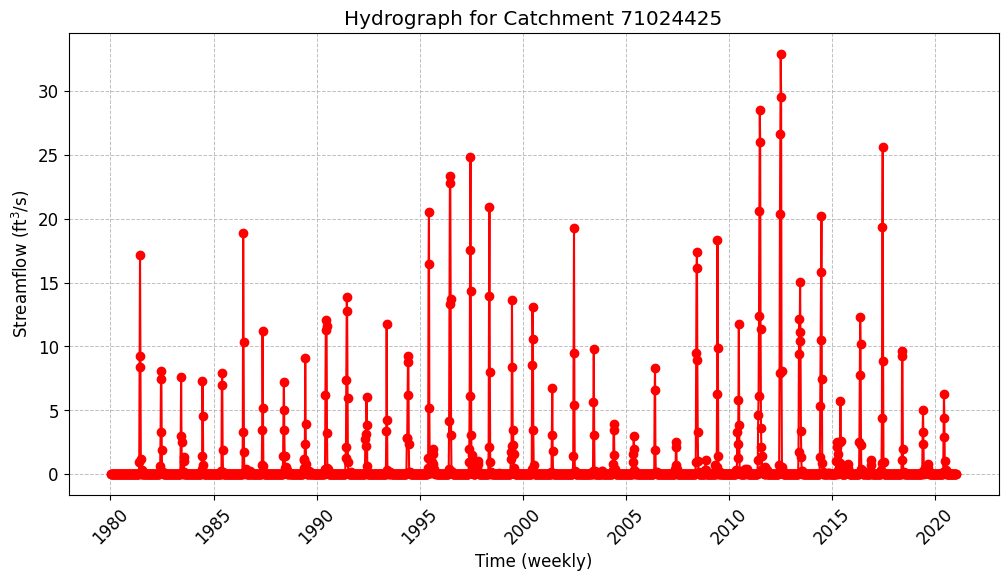

In [13]:
import zarr

from core.utils.dates import Dates
from core.data import txt_to_array
from core.post.plot_hydrograph import plot_hydrograph



#------------------------------------------#
# Choose a catchment by unit catchment ID (COMID) to plot.
COMID = 71024425
TARGET = 'flow_sim'

# Resample to 3-day prediction. Options: 'D', 'W', 'M', 'Y'.
RESAMPLE = 'W'

# Set the path to the zarr store of input data (containing COMIDs).
DATA_PATH = '/projects/mhpi/yxs275/model/generic_deltaModel_dhbv2.0/data/71_0' #'your/path/to/MERIT_input_sample/71_0'
#------------------------------------------#



print(f"HBV states and fluxes: {predictions.keys()} \n")


# 1. Get the streamflow predictions and daily timesteps of the prediction window.
pred = predictions[TARGET]
timesteps = Dates(config['predict'], config['dpl_model']['rho']).batch_daily_time_range

# Remove warm-up period to match model output (see Note above.)
timesteps = timesteps[config['dpl_model']['phy_model']['warm_up']:]


# 2. Load array of comids and get the index of the selected catchment.
root = zarr.open_group(DATA_PATH, mode='r+')
comids = root['COMID'][:]
print(f"First 20 available COMIDs: \n {comids[:20]} \n")

if COMID in comids:
    basin_idx = list(comids).index(COMID)
else:
    raise ValueError(f"Catchment with ID {COMID} not found in the MERIT dataset.")


# 3. Get the data for the chosen catchment and plot.
streamflow_pred_basin = pred[:, basin_idx].squeeze()

plot_hydrograph(
    timesteps,
    streamflow_pred_basin,
    streamflow_pred_basin,
    resample=RESAMPLE,
    title=f"Hydrograph for Catchment {COMID}",
    ylabel='Streamflow (ft$^3$/s)',
)